In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('restaurant_data.csv')
risks = {'None': 0, 'Moderate Risk': 2, 'Low Risk': 1, 'High Risk': 3}     ###changed 2 to 1 for 'low risk'
health_office = [37.778155, -122.418614]
df['miles_from_inspector'] = (((df.latitude - health_office[0])*69)**2 + ((df.longitude - health_office[1])*55)**2)**.5
df['risk_numeric'] = [risks[c] for c in df.risk_category]
df['time'] = [pd.to_datetime('{}/{}/{}'.format(r[1].day, r[1].month, r[1].year), format='%d/%m/%Y') for r in df.iterrows()]
df.head()

,month,day,year,business_id,risk_category,inspection_score,zipcode,latitude,longitude,miles_from_inspector,risk_numeric,time
0,2,26,2018,10030,None,100,94103,37.766864,-122.419014,0.779390,0,2018-02-26
1,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05
2,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05
3,4,26,2019,10083,Moderate Risk,86,94111,37.794024,-122.401299,1.451159,2,2019-04-26
4,9,19,2017,10280,Moderate Risk,92,94102,37.782034,-122.419777,0.275188,2,2017-09-19


In [27]:
'''
df['time_since'] = -1
for b in df.business_id.unique():
    dfb = df[df.business_id == b].sort_values('time', ascending =False)
    if len(dfb.time.unique()) > 1:
        last = max(dfb.time)
        prev = max([t for t in dfb.time if t < last])
        ind = dfb.index[0]
        since = last - prev
        df.loc[ind,'time_since'] = int(since.days)
'''

times = []
key_to_avg_time_between_mapping = {}     #maps time-business_id keys to the average time between all prior inspections
key_to_time_until = {}
for b in df.business_id.unique():
    dfb = df[df.business_id == b].sort_values('time', ascending = True)
    old_time = -1
    old_key = -1
    times_for_this_business = []
    for i, row in dfb.iterrows():
        time = row.time
        key = '{}{}'.format(row.business_id, row.time)
        if old_time == -1:
            key_to_avg_time_between_mapping[key] = None
        elif time != old_time:
            time_diff = np.abs(int((time - old_time).days))
            times.append(time_diff)
            times_for_this_business.append(time_diff)
            key_to_avg_time_between_mapping[key] = int(np.floor(np.mean(times_for_this_business)))
            key_to_time_until[old_key] = time_diff     
        old_time = time
        old_key = key

In [28]:
mean_time_diff = int(np.floor(np.mean(times)))
for i in key_to_avg_time_between_mapping:
    if key_to_avg_time_between_mapping[i] == None:
        key_to_avg_time_between_mapping[i] = mean_time_diff
        
mean_time_diff

388

In [29]:
#df = df.replace(-1,df[(df.time_since != -1) & (df.year != 2019)].time_since.mean())

df['time_since'] = df.apply(lambda row: key_to_avg_time_between_mapping['{}{}'.format(row.business_id, row.time)], axis = 1)
df['time_until'] = df.apply(lambda row: key_to_time_until.get('{}{}'.format(row.business_id, row.time), -1), axis = 1)

In [30]:
df.head(50)

,month,day,year,business_id,risk_category,inspection_score,zipcode,latitude,longitude,miles_from_inspector,risk_numeric,time,time_since,time_until
0,2,26,2018,10030,None,100,94103,37.766864,-122.419014,0.779390,0,2018-02-26,388,-1
1,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,388,598
2,9,5,2017,10083,Moderate Risk,81,94111,37.794024,-122.401299,1.451159,2,2017-09-05,388,598
3,4,26,2019,10083,Moderate Risk,86,94111,37.794024,-122.401299,1.451159,2,2019-04-26,598,-1
4,9,19,2017,10280,Moderate Risk,92,94102,37.782034,-122.419777,0.275188,2,2017-09-19,388,198
5,4,5,2018,10280,Low Risk,88,94102,37.782034,-122.419777,0.275188,1,2018-04-05,198,196
6,10,18,2018,10280,High Risk,81,94102,37.782034,-122.419777,0.275188,3,2018-10-18,197,134
7,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,197,134
8,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,197,134
9,10,18,2018,10280,Low Risk,81,94102,37.782034,-122.419777,0.275188,1,2018-10-18,197,134


In [32]:
X = df[df.year != 2019]
X = df[['time', 'business_id', 'risk_numeric', 'inspection_score', 'miles_from_inspector', 'time_since', 'time_until']]
max_times = {}
for i, row in X.iterrows():
    if row.business_id in max_times:
        max_times[row.business_id] = max([max_times[row.business_id], row.time])
    else:
        max_times[row.business_id] = row.time
X = X[X.time < X.apply(lambda row:max_times[row.business_id], axis=1)]

In [31]:
X.head()

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,time_since,violation_total
1,2017-09-05,10083,2,81,1.451159,388,2
4,2017-09-19,10280,2,92,0.275188,388,1
5,2018-04-05,10280,1,88,0.275188,198,1
6,2018-10-18,10280,3,81,0.275188,197,4
12,2017-05-23,10282,3,91,1.676005,388,1


In [33]:
max_risk = {}
counts = {}
for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    counts[key] = counts.get(key, 0) + 1
    if key in max_risk:
        max_risk[key] = max([max_risk[key], row.risk_numeric])
    else:
        max_risk[key] = row.risk_numeric

In [34]:
mask = []
seen = set()
for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    if key not in seen:
        mask.append(True)
        seen.add(key)
    else:
        mask.append(False)

In [35]:
X = X[mask]

for i, row in X.iterrows():
    key = '{}{}'.format(row.business_id, row.time)
    row.risk_numeric = max_risk[key]
    
X['violation_total'] = X.apply(lambda row: counts['{}{}'.format(row.business_id, row.time)], axis = 1)

In [36]:
X

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,time_since,time_until,violation_total
1,2017-09-05,10083,2,81,1.451159,388,598,2
4,2017-09-19,10280,2,92,0.275188,388,198,1
5,2018-04-05,10280,1,88,0.275188,198,196,1
6,2018-10-18,10280,3,81,0.275188,197,134,4
12,2017-05-23,10282,3,91,1.676005,388,385,1
...,...,...,...,...,...,...,...,...
3204,2016-12-22,71823,2,96,1.406523,388,960,1
3206,2017-10-06,71841,1,92,1.657285,388,448,1
3208,2016-10-05,71909,2,86,3.674226,388,434,3
3211,2017-12-13,71909,1,92,3.674226,434,434,1


In [48]:
y = X.time_until
y

1       598
4       198
5       196
6       134
12      385
       ... 
3204    960
3206    448
3208    434
3211    434
3212    191
Name: time_until, Length: 957, dtype: int64

In [75]:
X_features = X[[i for i in X.columns if i not in ['time_until', 'time', 'business_id']]]
X_features['intercept'] = 1

c:\users\alex\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
X_features

,risk_numeric,inspection_score,miles_from_inspector,time_since,violation_total,intercept
1,2,81,1.451159,388,2,1
4,2,92,0.275188,388,1,1
5,1,88,0.275188,198,1,1
6,3,81,0.275188,197,4,1
12,3,91,1.676005,388,1,1
...,...,...,...,...,...,...
3204,2,96,1.406523,388,1,1
3206,1,92,1.657285,388,1,1
3208,2,86,3.674226,388,3,1
3211,1,92,3.674226,434,1,1


In [77]:
beta = np.dot(np.dot(np.linalg.inv(np.dot(X_features.T, X_features)), X_features.T), y)

In [111]:
X_shuffle = X.sample(frac=1, random_state=123).reset_index(drop=True)
X_shuffle['intercept'] = 1
subsets = np.array_split(X_shuffle, 10)
all_resid = []
all_pred = []

for i in range(10):
    hold_out = subsets[i]
    train = pd.concat(subsets[0:i] + subsets[i+1:10])
    y = train.time_until
    X_features = train[[i for i in train.columns if i not in ['time_until', 'time', 'business_id']]]
    beta = np.dot(np.dot(np.linalg.inv(np.dot(X_features.T, X_features)), X_features.T), y)
    
    pred = np.dot(hold_out[[i for i in train.columns if i not in ['time_until', 'time', 'business_id']]], beta)
    resid = pred - hold_out.time_until
    all_pred.extend(pred)
    all_resid.extend(list(resid))
    
interval_size = pd.Series(all_resid).quantile(.95)
interval_size

225.0597823878081

In [110]:
cutoff

array([208.4106496 , 158.75693786, 146.80847562, 185.77491038,
       155.46473987, 187.07750891, 153.6139404 , 165.05893456,
       201.63217817, 189.89385331, 157.75787281, 107.41281637,
       144.11431746, 149.40299158, 144.01757871, 162.73932976,
       171.69223322, 129.44588139, 109.68326576, 177.26009327,
       203.5673239 , 180.43036145, 185.36375386, 153.80738437,
       207.95149141, 188.14753949, 117.15629002, 187.8802859 ,
       180.23851214, 171.87692027, 176.03517936, 200.91394307,
       177.61738751, 194.60417658, 139.62983514, 167.99006229,
       182.04254017, 163.10528648, 185.54387369, 191.9509908 ,
       180.4067588 , 155.4710648 , 163.94254287, 170.13500391,
       172.70977811, 176.31337413, 176.65385044, 145.22295062,
       131.36366054, 174.27261725, 172.04596588, 204.27622024,
       202.29311498, 200.20465931, 197.16416094, 171.75467407,
       169.36854664, 206.40231535, 194.19602535, 180.34616   ,
       182.0427505 , 173.26100105, 152.39951369, 183.92

In [83]:
pd.concat(subsets)

,time,business_id,risk_numeric,inspection_score,miles_from_inspector,time_since,time_until,violation_total
0,2016-10-06,33911,3,68,2.336897,388,461,4
1,2017-03-16,68615,2,73,1.716035,388,312,2
2,2017-02-01,59838,1,94,1.046170,388,537,1
3,2017-09-05,10083,2,81,1.451159,388,598,2
4,2017-05-03,32738,1,92,3.167822,388,393,2
...,...,...,...,...,...,...,...,...
952,2016-11-21,59599,1,94,0.725483,388,283,1
953,2016-12-21,25301,2,81,1.043386,388,393,1
954,2019-03-08,36571,1,85,4.119542,287,196,3
955,2017-05-18,61563,2,89,1.250148,388,806,1


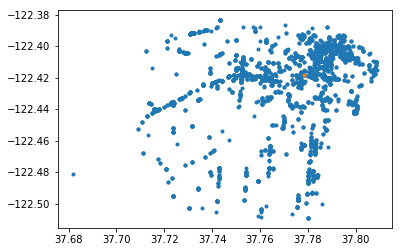

In [21]:
plt.plot(df.latitude, df.longitude, '.')
plt.plot([37.778155], [-122.418614], '.')

In [74]:
for r in range(4):
    filt = X_features[X_features.risk_numeric == r]
    print(filt.inspection_score.mean())

98.20930232558139
87.74245939675174
85.59654178674351
80.38970588235294
